# Introduction

Radial forging is widely used in industry to manufacture components for a broad range of sectors including automotive, medical, aerospace, rail and industrial. 

The Advanced Forming Research Centre (AFRC) at the University of Strathclyde, Glasgow, houses a GFM SKK10/R radial forge that has been used as a testbed for this project. 81 parts have been forged over one day of operation. 
Production process of one part is consisted of the following phases:

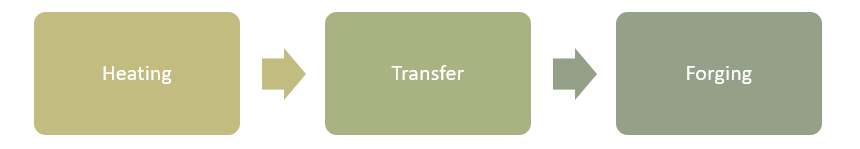

Each forged part is then measured using a CMM to provide dimensional output relative to a target specification and tolerances. Some of these measurements are presented in the following table:
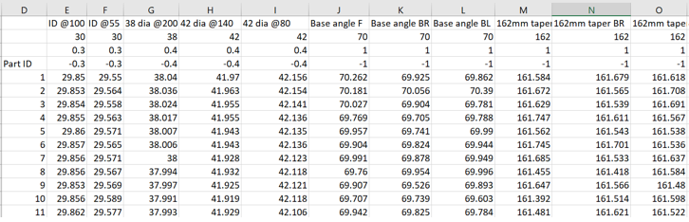

From available data of 81 parts, 99 sensors have been involved in the process of forging. Previously, in https://github.com/harislulic/Strathcylde_AFRC_machine_learning_tutorials the idea was to 
examine the correlation between relevant sensors and deviations from nominal dimensions of production parts. Only some of these 99 sensors were considered as significant. *Random forest regression* was performed between extracted features from these sensors and one column of target matrix (CMM measurements). See:https://github.com/harislulic/Strathcylde_AFRC_machine_learning_tutorials


## Content guidelines

This tutorial contains three notebooks:


First step is to examine if some other sensors can be also considered as relevant sensors. Interactive diagrams are going to be used for this purpose and this is going to be conducted for only one part because the same process is repeated for all other parts. Every sensor had 81 measurement cycles, collecting the samples from all three production phases: heating, transfer and forging. 

The next step is to add a white noise to every cycle and to make further analysis of features in frequency domain. This is going to be achieved by Discrete Fourier Transform (DFT) via software "PyDynamic." Duration of each phase varies from part to part, which causes different length of time signals, and consequently, different frequency bins in frequency domain. Two approaches contain solutions to this problem:

- A1: analysis of complete cycles, with padding - for every sensor, sampling points from the whole production process (heating, transfer and forging) will be taken into account and unequal signal length is going to be solved by adding some values at the end of the shorter time signals to achieve the length of the longest one. 3 - 4 cases of padding wil be compared.

- A2: sensors are going to be divided into two groups: heating sensors and forging sensors, depending on the phase for which they are considered as relevant. The part of time signals which describes that phase is going to be extracted. Heating and forging phases have similar duration for all cycles, and what actually causes the big difference in total length of time signals is *transfer phase*. Because of this, for heating sensors, the number of sampling points is going to correspond to the shortest duration of heating phase and for forging sensors,  the number of sampling points is going to correspond to the shortest duration of forging phase.

After DFT, data is going to be split into train and test. Methods such as: Weighted least squares and  Monte Carlo for least squares regression are going to be performed and their results on test data are going to be compared.

The workflow of this and other notebooks is presented on the image below:
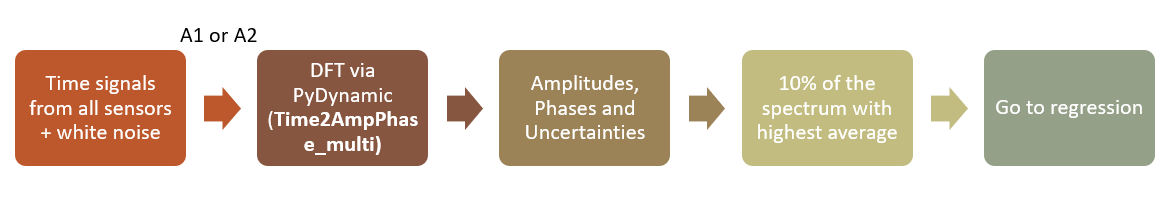



In [ ]:
import pandas as pd 
import time
#%pip install openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
np.random.seed(42)
from scipy.signal import find_peaks
from scipy import integrate
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import math
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data
import PyDynamic
from scipy import interpolate
from PyDynamic.uncertainty.propagate_DFT import GUM_DFT,DFT2AmpPhase,Time2AmpPhase_multi
import h5py
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

# 1 Relevant sensors

List `data` with length of 81 is containing matrix for each part, where columns are time series from sensors measurements. Column names are names of sensors, and row indices are samples numbers.

In [ ]:
data=[0]*81
for i in range(81):
    print("|"*(i+1),(i+1), end="\r")
    file_format="Scope"+str("{:04d}".format(i+1))+".csv"    
    data[i] = pd.read_csv(Path('Data')/'AFRC Radial Forge - Zenodoo Upload v3'/'Data'/'ScopeTraces'/file_format.format(i), header=0, encoding = 'unicode_escape')#, index_col=0)
    time.sleep(1)

Looking at column names of imported data gives us insight into sensors used for this measurement:

In [ ]:
data[0].head()

Concatenating the data from all part will make one long time series. Index will be recreated, and timeline will be adjusted. Before concatenating part labels will be added.

In [ ]:
for index,df in enumerate(data):
    df['traceID'] = index+1

In [ ]:
merged_data = pd.concat(data, ignore_index=True)
merged_data['Time [s]']=(merged_data.index.values)/100.0

Now, we will have a look in data for only one part, because for other parts production cycle consists of the same phases.

In [ ]:
merged_data.iloc[0:23328].to_excel("Merged_data_from_1st_sensor.xlsx")

In [ ]:
first_sensor=pd.read_excel("Merged_data_from_1st_sensor.xlsx")

Sensors that are not in use or are the part of auxiliary process measurement will be dropped:   

In [ ]:
used_sensors=first_sensor.drop(['hydraulic low pressure [bar]','hydraulic high pressure [bar]','A_NOM_Force [kN]','B_ACTpos [mm]','B_ACT_Force [kN]',"B_ACTspd [mm/min]","B_NOMpos [mm]","B_OUT [%]","B_NOMspd [mm/min]","B_NOM_Force [kN]","Feedback B [%]","DB_NOM_Force [kN]","D_ACTpos [mm]","D_ACT_Force [kN]","D_ACTspd [mm/min]","D_NOMpos [mm]","D_OUT [%]","D_NOMspd [mm/min]","D_NOM_Force [kN]", "Feedback D [%]","Lub_ActSpd [rpm]","Hyd_ActSpd [rpm]","O_EMERG","STP || EM","O_MASTOP","$U_GH_NOMVAL_1 (U25W1)","$H1P_Y12 (U11S17)","$H1P_Y11 (U11S7)","$U_GH_NOMEXT_2 (U26S1)","$U_GH_HEATON_2 (U26S0)","$U_GH_NOMEXT_1 (U25S1)"],axis=1)

We can have a look into rest of the data:

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,15)
mpl.rc('font', **font)

def overview(num_of_sensor):
    names=list(used_sensors.columns.values)
    plt.plot(used_sensors['Time [s]'],used_sensors[names[num_of_sensor+3]])
    plt.xlabel('Time [s]')
    plt.title(names[num_of_sensor+3])
    plt.ylabel('Values');
interact(overview,num_of_sensor=widgets.IntSlider(min=0, max=99, step=1))

Sensors chosen as relevant sensors for specific production phase (heating/transfer/forging) in *Strathcylde_AFRC_machine_learning_tutorials* as well as those which had been dropped as non - relevant will not be considered in the next plot. Only the rest of the sensors will be analyzed.

In [ ]:
other_sensors=used_sensors.drop(['Schlagzahl [1/min]',"Power [kW]","Force [kN]","A_ACT_Force [kN]","A_NOMpos [mm]","A_ACTpos [mm]","DB_ACT_Force [kN]","SBA_ActPos [mm]","IP_ActPos [mm]","IP_NomPos","TMP_Ind_U1 [°C]","TMP_Ind_F [°C]","L_ACTpos [mm]","L_NOMpos [mm]","R_ACTpos [mm]","R_NOMpos [mm]","EXZ_pos [deg]",'A_ACTspd [mm/min]','A_NOMspd [mm/min]','A_OUT [%]','Feedback A [%]','DB_ACTpos [mm]','DB_ACTspd [mm/min]','DB_NOMpos [mm]','DB_OUT [%]','DB_NOMspd [mm/min]','Feedback DB [%]','L_ACTspd [mm/min]','L_OUT [%]','L_NOMspd [mm/min]','Feedback L [%]','R_ACTspd [mm/min]','R_OUT [%]','R_NOMspd [mm/min]','Feedback R [%]','SBA_NomPos [mm] [mm]','SBA_OUT [%]','Feedback SBA [%]',"ForgingBox_Temp","$U_GH_HEATON_1 (U25S0).1"],axis=1)

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,5)
mpl.rc('font', **font)
def overview_other_sensors(num_of_sensor):
   
    plt.plot(other_sensors['Time [s]'], other_sensors[[num_of_sensor]])
    plt.xlabel('Time [s]')
    plt.title(num_of_sensor)
    plt.ylabel('Values');
interact(overview_other_sensors,num_of_sensor=list(other_sensors.columns[3:].values))

Based on the plot, additional sensors that will be considered are:
- A_ges_vibr
- INDA_NOMpos [deg]
- FRC_Volt
- RamRetract_ActSpd [rpm]
- W1 Durchfluss [I]
- W2 Durchfluss [I]
- L1.R_B41 (bar)

In [ ]:
other_sensors.columns.values

In [ ]:
used_sensors=used_sensors.drop(['EXZ_pos [deg]','DB_ACTpos [mm]',"IP_ActSpd [mm/min]","IP_NomSpd [mm/min]",'INDA_ACTpos [deg]','INDA_NOMspd [U/min]','INDA_OUT [%]','INDA_ACTspd [U/min]',
       'Speed Vn_1 [rpm]', 'NOMforceSPA [kN]', '$F_F41L (I14S8)','SPA_OUT [%]','Feedback_SPA [%]','IP_Out [%]',
       'ACTforceSPA [kN]', '$U_GH_HEATON_1 (U25S0)','$E_GH_FAULT_2 (I26S21)','L_ACTspd [mm/min]',
       'R_ACTspd [mm/min]', 'SBA_NomPos [mm] [mm]', 'A_ACTspd [mm/min]',
       'DB_ACTspd [mm/min]','SBA_OUT [%]', 'DB_NOMpos [mm]', 'L_OUT [%]', 'R_OUT [%]', 'Feedback SBA [%]',
       'A_OUT [%]', 'DB_OUT [%]', 'L_NOMspd [mm/min]',
       'R_NOMspd [mm/min]','A_NOMspd [mm/min]',"Feedback A [%]",
       'Feedback DB [%]','DB_NOMspd [mm/min]', 'Feedback L [%]', 'Feedback R [%]','$E_GH_FAULT_1 (I25S21)', '$B12R_Y11 (U14S16)', 'Unnamed: 0','c01w', 'c02w', 'Timer Tick [ms]', 'Block-Nr','traceID','Time [s]','$U_GH_HEATON_1 (U25S0).1'],axis=1)

Total number of sensors which will be analyzed is:

In [ ]:
len(used_sensors.columns)

and they are:

In [ ]:
used_sensors.columns.values

These sensors will be analyzed for all parts:

In [ ]:
parts=[None]*81
for i in range(len(data)):
    parts[i]=data[i][used_sensors.columns.values].copy()

In [ ]:
parts[0].head()

So, there were 99 sensors at the beginning. Sensors which are not in use or are used in auxilliary process measurements were droped. Other sensors were analyzed and 24 have been considered as relevant.

# 2 A1: Features extraction - Padding

## 2.1. Uncertainty propagation

For the uncertainty propagation, software package PyDynamic will be used. The software is based on Discrete Fourier Transform (DFT) with some FFT algorithm.
The time domain signal is *x(t).* A white noise will be added to this signal:

$$x_{n}(t) = x(t)+\epsilon$$

White noise has normal distribution ${\mathcal {N}}(0 ,\sigma ^{2})$ and standard deviation that can be specified by user. 

For every sensor, measurements of each part will be considered as one cycle. It means that for every sensor, there will be 81 cycle because there are 81 parts.

In [ ]:
from PyDynamic import __version__ as version
version

Period of sampling is 0.01 s. This means that signals are sampled at frequency of 100 Hz.The number of sampling points (signal length) varies from part to part and because of this, cycles have to be separated into list elements. Unequal signal length will be considered in the next steps.

In [ ]:
sensors=[None]*(parts[0].shape[1])
for p in range (parts[0].shape[1]):
    sensors[p] = [None]*(len(parts))
    for k in range(len(parts)):
            sensors[p][k]=parts[k].iloc[:,p].values


The time domain signal will be presented in frequency domain with associated uncertainty *ux* as noise variances $\sigma ^{2}$ and standard deviation that can be specified by user. 

In [ ]:
sigma=float(input("Enter the value of white noise standard deviation:"))

In [ ]:
#adding white noise
for i in range((len(sensors))):
    for k in range((len(sensors[i]))):
           sensors[i][k]=sensors[i][k]+ np.random.randn(len(sensors[i][k]))*sigma

In [ ]:
sensors[0][0]

Number of sampling points for the first sensor and first cycle (part):

In [ ]:
len(sensors[0][0])

Function `Perform_Fourier` uses three functions from PyDynamic: *GUM_DFT*, *DFT2AmpPhase*, *GUM_DFTfreq*. First, by GUM_DFT applied on time signals and related uncertainties, real and imaginary parts can be obtained and stored in vector *F* , as well as their uncertainties (vector *UF*). When only white noise is considered, all off-diagonal elements of *UF* are equal to zero. For this reason, *UF* is vector and not covariance matrix. 

Then, from the results of *GUM_DFT*, function *DFT2AmpPhase* will provide amplitudes, phases and their uncertainties.

It is possible that PyDynamic raises a warning, such as:
*Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.*

This means that amplitudes are small relative to the uncertainty associated with real and imaginary parts and the GUM uncertainty propagation becomes unreliable and a Monte Carlo method is recommended instead.The default threshold in GUM2DFT is 1.0, but may be adjusted for specific applications.

Function `Perform_Fourier` returns:
- freq -  From Nyquist's theorem we know that the largest frequency component in the original signal must be half the sampling frequency. So, from a number of points of signals (*n_of_sampling_pts*) sampled at 100Hz we get (*n_of_sampling_pts*/2+1) unique spectral points covering the range 0 to 50Hz.,
- A - amplitudes of signals in frequency domain 
- P - phases of signals in frequency domain 
- UAP - uncertainties of time domain signals (standard squared uncertainties of amplitudes,covariance between amplitudes and phases, and standard squared uncertainties of phases).

In [ ]:
def Perform_Fourier(sensor,sigma):
    n_of_sampling_pts=len(sensor)
    sample_period=0.01
    time=0.01*n_of_sampling_pts# number of sampling points
    time_steps=np.arange(0, time, 0.01)  
    freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(n_of_sampling_pts,float(time)/n_of_sampling_pts)
    ux=sigma**2
    N=n_of_sampling_pts//2+1
    selector=np.arange(N)
    ns=len(selector)
    A=np.zeros(ns)
    P=np.zeros_like(A)
    UAP=np.zeros(3*ns)
    X,UX=GUM_DFT(sensor,ux)
    A, P, UAP_m = DFT2AmpPhase(X, UX, keep_sparse=True)
    UAP[:ns] = UAP_m.data[0][:N][selector]
    UAP[ns:2*ns] = UAP_m.data[1][UAP_m.offsets[1]:2*N+UAP_m.offsets[1]][selector]
    UAP[ 2*ns:] = UAP_m.data[0][N:][selector]
    return freq,A,P,UAP

### 2.1.1 Unequal length of time signals

Since the length of time signals varies, Fourier transform will be first performed for the cycles with minimum and maximum length. These two time signals will be considered as two extreme cases for solving this problem. 

In [ ]:
cycle_length=[None]*(len(parts))
for i in range(len(parts)):
    cycle_length[i]=(parts[i].shape[0])

In [ ]:
max_length=max(cycle_length)
print("Maximum length of time signals is:",max_length, "and it is in",cycle_length.index(max_length),". cycle")

In [ ]:
min_length=min(cycle_length)
print("Minimum length of time signals is:",min_length, "and it is in",cycle_length.index(min_length),". cycle")

Fourier transform of time signals in 42nd cycle for all of 24 sensors:

In [ ]:
A_sensors_42=[None]*len(sensors)
P_sensors_42=[None]*len(sensors)
UAP_sensors_42=[None]*len(sensors)
freq_42=[None]*len(sensors)
for i in range(len(sensors)):
    freq_42[i],A_sensors_42[i], P_sensors_42[i], UAP_sensors_42[i]=Perform_Fourier(sensors[i][42],sigma)
                        

Fourier transform of time signals in 17th cycle for all of 24 sensors:

In [ ]:
A_sensors_17=[None]*len(sensors)
P_sensors_17=[None]*len(sensors)
UAP_sensors_17=[None]*len(sensors)
freq_17=[None]*len(sensors)
for i in range(len(sensors)):
    freq_17[i],A_sensors_17[i], P_sensors_17[i], UAP_sensors_17[i]=Perform_Fourier(sensors[i][17],sigma)

The next plot shows the differences in amplitudes between both cycles. Be aware of different frequency bins because of the length of time signals.

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)
def overview_cycles(i):
    plt.subplot(2,1,1)
    plt.plot(freq_17[i],A_sensors_17[i], label="17th cycle")
    plt.xlabel('Frequencies [Hz]')
    plt.ylabel('Amplitudes');
    plt.yscale('log')
    num_of_sensor=list(parts[0].columns.values)
    plt.title(num_of_sensor[i])
    plt.legend()
    plt.subplot(2,1,2)
    plt.yscale('log')
    plt.plot(freq_42[i],A_sensors_42[i],label="42nd cycle")
    plt.xlabel('Frequencies [Hz]')
    plt.ylabel('Amplitudes');
    plt.legend()
interact(overview_cycles,i=widgets.IntSlider(min=0, max=24, step=1))

### 2.1.2 Value padding

In order to analyze the amplitudes at the same frequencies for all cycles, the simplest way is to add some values at the end of short time series so that they have the length of the longest one. By appending artificial zeros to the signal, the frequency grid becomes denser when applying the DFT. 

As a reminder, the longest time signal has length: 

In [ ]:
max_length=max(cycle_length)
print("Maximum length of time signals is:",max_length, "and it is in",cycle_length.index(max_length),". cycle")

The shortest time signal has length:

In [ ]:
min_length=min(cycle_length)
print("Minimum length of time signals is:",min_length, "and it is in",cycle_length.index(min_length),". cycle")

Three cases of adding values will be examined:
- zeros
- mean value of 100 last elements of time signal
- last value of time signal.
The effect of adding values will be analyzed on the shortest time signal (17) for all sensors.

Function `add_value` is created. It will take time signals for all parts as arguments and return *sensors_value_0*, *sensors_value_mean*, *sensors_value_last* with values 0, mean value and last element value respectively added to the end of time signals.

In [ ]:
def add_value(all_parts):
    sensors_value_0=[None]*(all_parts[0].shape[1])
    sensors_value_mean=[None]*(all_parts[0].shape[1])
    sensors_value_last=[None]*(all_parts[0].shape[1])
    for p in range (all_parts[0].shape[1]):
        sensors_value_0[p]=np.zeros((len(all_parts),max_length))
        sensors_value_mean[p]=np.zeros_like(sensors_value_0[p])
        sensors_value_last[p]=np.zeros_like(sensors_value_0[p])
        for k in range(len(all_parts)):
                if all_parts[k].shape[0]==max_length:
                    sensors_value_0[p][k,:]=all_parts[k].iloc[:,p].values
                    sensors_value_mean[p][k,:]=sensors_value_0[p][k,:]
                    sensors_value_last[p][k,:]=sensors_value_0[p][k,:]
                else:
                    sensors_value_0[p][k,:all_parts[k].shape[0]]=parts[k].iloc[:,p].values
                    sensors_value_mean[p][k,:all_parts[k].shape[0]]= sensors_value_0[p][k,:all_parts[k].shape[0]]
                    sensors_value_last[p][k,:all_parts[k].shape[0]]= sensors_value_0[p][k,:all_parts[k].shape[0]]
                    sensors_value_0[p][k,parts[k].shape[0]:]=0
                    sensors_value_mean[p][k,parts[k].shape[0]:]=np.mean(all_parts[k].iloc[-100:,p].values)
                    sensors_value_last[p][k,parts[k].shape[0]:]=all_parts[k].iloc[-1,p]
    return sensors_value_0,sensors_value_mean,sensors_value_last

##### Function execution

In [ ]:
sensors_zero,sensors_mean,sensors_last=add_value(parts)

In [ ]:
sensors_zero[0].shape

In [ ]:
# adding white noise:

for i in range((len(sensors_zero))):
    for k in range((sensors_zero[0].shape[0])):
        sensors_zero[i][k,:]=sensors_zero[i][k,:]+ np.random.randn(sensors_zero[i].shape[1])*sigma
        sensors_mean[i][k,:]=sensors_mean[i][k,:]+ np.random.randn(sensors_mean[i].shape[1])*sigma
        sensors_last[i][k,:]=sensors_last[i][k,:]+ np.random.randn(sensors_last[i].shape[1])*sigma

Fourier transform into frequency domain will be performed for 17th cycle for all cases.

In [ ]:
A_sensors_17_zero=[None]*len(sensors_zero)
P_sensors_17_zero=[None]*len(sensors_zero)
UAP_sensors_17_zero=[None]*len(sensors_zero)
freq_17_zero=[None]*len(sensors_zero)
for i in range(len(sensors_zero)):
    freq_17_zero[i],A_sensors_17_zero[i], P_sensors_17_zero[i], UAP_sensors_17_zero[i]=Perform_Fourier(sensors_zero[i][17],sigma)
                    

In [ ]:
A_sensors_17_mean=[None]*len(sensors_mean)
P_sensors_17_mean=[None]*len(sensors_mean)
UAP_sensors_17_mean=[None]*len(sensors_mean)
freq_17_mean=[None]*len(sensors_mean)
for i in range(len(sensors_mean)):
    freq_17_mean[i],A_sensors_17_mean[i], P_sensors_17_mean[i], UAP_sensors_17_mean[i]=Perform_Fourier(sensors_mean[i][17],sigma)
                    

In [ ]:
A_sensors_17_last=[None]*len(sensors_last)
P_sensors_17_last=[None]*len(sensors_last)
UAP_sensors_17_last=[None]*len(sensors_last)
freq_17_last=[None]*len(sensors_last)
for i in range(len(sensors_last)):
    freq_17_last[i],A_sensors_17_last[i], P_sensors_17_last[i], UAP_sensors_17_last[i]=Perform_Fourier(sensors_last[i][17],sigma)
                    

### 2.1.3 Padding based on cubic spline interpolation

Spline interpolation requires two essential steps: 

- a spline representation of the curve is computed, and 
- the spline is evaluated at the desired points. 

The direct method of representing a curve and obtaining spline coefficients is in a two- dimensional plane using the function *splrep*. The first two arguments are the only ones required, and these provide the x-axis and y-axis components of the curve. The normal output is a 3-tuple,(*t*,*c*,*k*), containing the knot-points,*t*, the coefficients *c* and the order *k* of the spline. The default spline order is cubic.

The keyword argument, *s* , is used to specify the amount of smoothing to perform during the spline fit. If no smoothing is desired a value of *s*=0 should be passed to the routines.

Once the spline representation of the data has been determined, functions are available for evaluating the spline (*splev*). 

To evaluate the spline, new values of x-axis are needed and actually, x-axis values are time steps. For each cycle, number of additional points on x-axis depends on the difference between its cycle length and the highest cycle length. Difference is divided by 100 because sampling period is 100 ms (or 0.01 s)

In [ ]:
time_diff=[None]*len(cycle_length)
for i in range(len(cycle_length)):
    time_diff[i]=(cycle_length[42]-cycle_length[i])/100

First, cubic spline is created based on the original signal length and that is how variable tck is obtained. Then, this spline is used to obtain new y-axis values.

In [ ]:

sensors_spl=[None]*(parts[0].shape[1])
   
for p in range (parts[0].shape[1]):
    sensors_spl[p]=np.zeros((len(parts),max_length))
        
    for k in range(len(parts)):
        if parts[k].shape[0]==max_length:
            sensors_spl[p][k,:]=parts[k].iloc[:,p].values
                    
        else:
            time_steps=np.arange(0,time_diff[k],0.01)   
            x = np.arange(0,cycle_length[k]* 0.01, 0.01)
            y = parts[k].iloc[:,p].values
            tck = interpolate.splrep(x, y, s=0)
            xnew = np.arange(0,time_diff[k],0.01)   
            ynew = interpolate.splev(xnew, tck, der=0)
            sensors_spl[p][k,:parts[k].shape[0]]=parts[k].iloc[:,p].values
            sensors_spl[p][k,parts[k].shape[0]:]=ynew

In [ ]:
# adding white noise:

for i in range((len(sensors_spl))):
    for k in range((sensors_spl[0].shape[0])):
        sensors_spl[i][k,:]=sensors_spl[i][k,:]+ np.random.randn(sensors_spl[i].shape[1])*sigma

Now, Fourier transform can be perfomed.

In [ ]:
A_sensors_17_spl=[None]*len(sensors_spl)
P_sensors_17_spl=[None]*len(sensors_spl)
UAP_sensors_17_spl=[None]*len(sensors_spl)
freq_17_spl=[None]*len(sensors_spl)
for i in range(len(sensors_spl)):
    freq_17_spl[i],A_sensors_17_spl[i], P_sensors_17_spl[i], UAP_sensors_17_spl[i]=Perform_Fourier(sensors_spl[i][17],sigma)
                    

The next plot shows the amplitudes for given frequencies for the 17th cycle with added zero value, mean value, last element value and cubic spline. It can be seen that deviation of amplitudes for zero padding is often the most significant. That is shown on the joint, but also in separate plots. Note that, ('Amplitudes - without padding') corresponds to different frequency bins.

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (25,25)
mpl.rc('font', **font)
def overview_amplitudes(i):
    plt.plot(freq_17[i],A_sensors_17[i],label=  'Amplitudes - without padding')
    plt.plot(freq_17_zero[i],A_sensors_17_zero[i], label=  'Amplitudes - zero padding')
    plt.plot(freq_17_mean[i],A_sensors_17_mean[i],label=  'Amplitudes - mean padding')
    plt.plot(freq_17_last[i],A_sensors_17_last[i], label='Amplitudes - last element padding' )
    plt.plot(freq_17_spl[i],A_sensors_17_spl[i], label=  'Amplitudes - spline interpolation')
    plt.yscale('log')
    plt.ylabel('Amplitudes');
    num_of_sensor=list(parts[0].columns.values)
    plt.title(num_of_sensor[i])
    plt.legend()

interact(overview_amplitudes,i=widgets.IntSlider(min=0, max=24, step=1))

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (25,25)
mpl.rc('font', **font)
def overview_amplitudes(i):

    num_of_sensor=list(parts[0].columns.values)
    plt.title(num_of_sensor[i])
    plt.subplot(4,1,1)
    plt.plot(freq_17_zero[i],A_sensors_17_zero[i],label=  'Amplitudes - zero padding')
    plt.plot(freq_17[i],A_sensors_17[i],label=  'Amplitudes - without padding')
    plt.yscale('log')
    plt.ylabel('Amplitudes ');
    plt.legend()
    plt.title(num_of_sensor[i])
    plt.subplot(4,1,2)
    plt.plot(freq_17_mean[i],A_sensors_17_mean[i],label=  'Amplitudes - mean value padding')
    plt.plot(freq_17[i],A_sensors_17[i],label=  'Amplitudes - without padding')
    plt.yscale('log')
    plt.ylabel('Amplitudes ');
    plt.legend()
    plt.subplot(4,1,3)
    plt.plot(freq_17_last[i],A_sensors_17_last[i],label=  'Amplitudes - last element padding')
    plt.plot(freq_17[i],A_sensors_17[i],label=  'Amplitudes - without padding')
    plt.yscale('log')
    plt.subplot(4,1,4)
    plt.plot(freq_17_spl[i],A_sensors_17_spl[i],label=  'Amplitudes - spline interpolation')
    plt.plot(freq_17[i],A_sensors_17[i],label=  'Amplitudes - without padding')
    plt.xlabel('Frequencies [Hz]')
    plt.yscale('log')
    plt.ylabel('Amplitudes ' );
    plt.legend()

interact(overview_amplitudes,i=widgets.IntSlider(min=0, max=24, step=1))


The effect of padding with some values will also be checked through rescaling DFT values with $$\frac{1}{length * 0.01}$$,  where *length* corresponds to the number of points for every signal (its length) and 0.01 represents the sampling period of 0.01s. Comparisons for different cases of padding will be shown on the joint and separate plots.

In [ ]:
A_sensors_17_zero_scaled=[None]*len(sensors_last)
A_sensors_17_last_scaled=[None]*len(sensors_last)
A_sensors_17_mean_scaled=[None]*len(sensors_last)
A_sensors_17_scaled=[None]*len(sensors_last)
A_sensors_17_spl_scaled=[None]*len(sensors_spl)

for k in range(len(sensors_mean)):
    A_sensors_17_scaled[k]=A_sensors_17[k]*(1/(0.01*cycle_length[17]))
    A_sensors_17_spl_scaled[k]=A_sensors_17_spl[k]*(1/(0.01*cycle_length[17]))
    A_sensors_17_zero_scaled[k]=A_sensors_17_zero[k]*(1/(0.01*cycle_length[17]))
    A_sensors_17_last_scaled[k]=A_sensors_17_last[k]*(1/(0.01*cycle_length[17]))
    A_sensors_17_mean_scaled[k]=A_sensors_17_mean[k]*(1/(0.01*cycle_length[17]))

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (25,20)
mpl.rc('font', **font)
def overview_amplitudes_scaled(i):
    
    plt.plot(freq_17[i],A_sensors_17_scaled[i],label=  'Amplitudes - without padding')
    plt.plot(freq_17_zero[i],A_sensors_17_zero_scaled[i], label=  'Amplitudes - zero padding')
    plt.plot(freq_17_mean[i],A_sensors_17_mean_scaled[i], label='Amplitudes - mean element padding' )
    plt.plot(freq_17_last[i],A_sensors_17_last_scaled[i], label='Amplitudes - last element padding' )
    plt.plot(freq_17_spl[i],A_sensors_17_spl_scaled[i], label=  'Amplitudes - spline interpolation')
    plt.yscale('log')
    plt.ylabel('Amplitudes');
    num_of_sensor=list(parts[0].columns.values)
    plt.title(num_of_sensor[i])
    plt.legend()
    plt.xlabel('Frequencies [Hz]')
interact(overview_amplitudes_scaled,i=widgets.IntSlider(min=0, max=24, step=1))

In [ ]:
A_sensors_17_xxscaled=[None]*len(sensors)
for k in range(len(sensors)):
    A_sensors_17_xxscaled[k]=A_sensors_17[k]*(1/(0.01*cycle_length[17]))

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (25,20)
mpl.rc('font', **font)
def overview_amplitudes_scaled(i):
    
    plt.plot(freq_17[i], A_sensors_17_scaled[i],label=  'Amplitudes - without padding')
    plt.plot(freq_17_zero[i],A_sensors_17_zero_scaled[i], label=  'Amplitudes - zero padding')
    plt.plot(freq_17_mean[i],A_sensors_17_mean_scaled[i], label='Amplitudes - mean element padding' )
    plt.plot(freq_17_last[i],A_sensors_17_last_scaled[i], label='Amplitudes - last element padding' )
    plt.plot(freq_17_spl[i],A_sensors_17_spl_scaled[i], label=  'Amplitudes - spline interpolation')
    plt.yscale('log')
    plt.ylabel('Amplitudes');
    num_of_sensor=list(parts[0].columns.values)
    plt.title(num_of_sensor[i])
    plt.legend()
    plt.xlabel('Frequencies [Hz]')
interact(overview_amplitudes_scaled,i=widgets.IntSlider(min=0, max=24, step=1))

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (25,25)
mpl.rc('font', **font)
def overview_amplitudes(i):

    num_of_sensor=list(parts[0].columns.values)
    
    plt.subplot(4,1,1)
    plt.plot(freq_17_zero[i],A_sensors_17_zero_scaled[i],label=  'Amplitudes - zero padding')
    plt.plot(freq_17[i],A_sensors_17_scaled[i],label=  'Amplitudes - without padding')
    plt.yscale('log')
    plt.ylabel('Amplitudes ');
    plt.title(num_of_sensor[i])
    plt.legend()
    plt.subplot(4,1,2)
    plt.plot(freq_17_mean[i],A_sensors_17_mean_scaled[i],label=  'Amplitudes - mean value padding')
    plt.plot(freq_17[i],A_sensors_17_scaled[i],label=  'Amplitudes - without padding')
    plt.yscale('log')
    plt.ylabel('Amplitudes ');
    plt.legend()
    plt.subplot(4,1,3)
    plt.plot(freq_17_last[i],A_sensors_17_last_scaled[i],label=  'Amplitudes - last element padding')
    plt.plot(freq_17[i],A_sensors_17_scaled[i],label=  'Amplitudes - without padding')
    plt.yscale('log')
    plt.legend()
    plt.subplot(4,1,4)
    plt.plot(freq_17_spl[i],A_sensors_17_spl_scaled[i],label=  'Amplitudes - spline interpolation')
    plt.plot(freq_17[i],A_sensors_17_scaled[i],label=  'Amplitudes - without padding')
    plt.xlabel('Frequencies [Hz]')
    plt.yscale('log')
    plt.ylabel('Amplitudes ' );
    plt.legend()
interact(overview_amplitudes,i=widgets.IntSlider(min=0, max=24, step=1))


For some sensors padding with zeros shows big deviations from other cases because these sensors are active during the whole production process of the part. For example, sensor "Power", denoting the power of forging force, has non-zero values in time signals even in other phases than forging. Adding zeros changes the total nature of these signals.

Another check: N% of the highest amplitudes from the frequency domain of shortest time signal in:

a) its original length

b) length with zeros added at the end

c) length with mean value added at the end

d) length with last element value added at the end

will be compared.

The percentage has been chosen as an arbitrary number. It can be user-defined.

Function `sort_amplitudes` will sort all the amplitudes and return number *N* of highest amplitudes for all cases of 17th cycle.

In [ ]:
percentage=input("Enter the percentage of spectrum to be sorted:")
N=(round((float(percentage)/100)*max_length))

In [ ]:
def sort_amplitudes (amplitudes,N):
    Sorted_amplitudes=np.argsort(amplitudes)[::-1]
    N_highest_amplitudes= amplitudes[Sorted_amplitudes[:N]]

    return N_highest_amplitudes

##### Function execution

In [ ]:
N_highest_amplitudes_17=[None]*len(sensors)
N_highest_amplitudes_17_zero=[None]*len(sensors_zero)
N_highest_amplitudes_17_mean=[None]*len(sensors_mean)
N_highest_amplitudes_17_last=[None]*len(sensors_last)
N_highest_amplitudes_17_spl=[None]*len(sensors_spl)
for i in range(len(sensors)):
    N_highest_amplitudes_17[i]= sort_amplitudes(A_sensors_17[i],N)
    N_highest_amplitudes_17_zero[i]= sort_amplitudes(A_sensors_17_zero[i],N)
    N_highest_amplitudes_17_mean[i]=sort_amplitudes(A_sensors_17_mean[i],N)
    N_highest_amplitudes_17_last[i]=sort_amplitudes(A_sensors_17_last[i],N)
    N_highest_amplitudes_17_spl[i]=sort_amplitudes(A_sensors_17_spl[i],N)

The highest amplitudes for 17th cycle of all sensors are presented in the plot below. We can see that neither of padding cases perfectly matches the highest amplitudes without padding, but all except zero padding look similar. Because of that, zero padding as an extreme case and one of these similar cases (actually, padding with spline) will be chosen for the further analysis.

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,25)
mpl.rc('font', **font)
def amplitudes_zero(i):
    num_of_sensor=list(parts[0].columns.values)
    plt.plot(np.arange(N),(N_highest_amplitudes_17[i]),label="Amplitudes - without padding" )
    plt.ylabel("Amplitudes") 
    plt.title(num_of_sensor[i])
    plt.plot(np.arange(N),(N_highest_amplitudes_17_zero[i]),label="Amplitudes - zero padding")

    plt.plot(np.arange(N),(N_highest_amplitudes_17_mean[i]),label="Amplitudes mean value padding")

    plt.plot(np.arange(N),(N_highest_amplitudes_17_last[i]),label="Amplitudes - last element padding")
    plt.plot(np.arange(N),(N_highest_amplitudes_17_spl[i]),label="Amplitudes - spline")
    plt.yscale("log")
    plt.legend()
interact(amplitudes_zero,i=widgets.IntSlider(min=0, max=24, step=1))    

Fourier transform for all sensors and cycles will be performed. This will result with amplitudes, phases and their uncertainties. For simplicity, the focus will be on the amplitudes and their standard squared uncertainties.  

In [ ]:

A_df=[None]*len(sensors_last)
UAP_df=[None]*len(sensors_last)
P_df=[None]*len(sensors_last)
for i in range(len(sensors_last)):
    A_df[i],P_df[i],UAP_df[i]=Time2AmpPhase_multi(sensors_spl[i],np.ones(sensors_spl[i].shape[0])*sigma**2)

Data will be written to the .hdf5 file in order to avoid long-lasting calculation everytime when the Jupyter Notebook is opened

In [ ]:
import h5py
hf_a = h5py.File('Amplitudes_spl.hdf5', 'w')
hf_p=h5py.File('Phases_spl.hdf5', 'w')
hf_uap=h5py.File('Uncertainties_spl.hdf5', 'w')

In [ ]:
for i in range(len(sensors_spl)):
    hf_a["A_df"+str(i)]=A_df[i]
    hf_p["P_df"+str(i)]=P_df[i]
    hf_uap["UAP"+str(i)]=UAP_df[i]

In [ ]:
from PyDynamic.uncertainty.propagate_DFT import Time2AmpPhase_multi
A_df_zero=[None]*len(sensors_zero)
UAP_df_zero=[None]*len(sensors_zero)
P_df_zero=[None]*len(sensors_zero)
for i in range(len(sensors_zero)):
    A_df_zero[i],P_df_zero[i],UAP_df_zero[i]=Time2AmpPhase_multi(sensors_zero[i],np.ones(sensors_zero[i].shape[0])*sigma**2)

In [ ]:
hf_a_zero = h5py.File('Amplitudes_zero.hdf5', 'w')
hf_p_zero = h5py.File('Phases_zero.hdf5', 'w')
hf_uap_zero=h5py.File('Uncertainties_zero.hdf5', 'w')

In [ ]:
for i in range(len(sensors_zero)):
    hf_a_zero["A_df"+str(i)]=A_df_zero[i]
    hf_p_zero["P_df"+str(i)]=P_df_zero[i]
    hf_uap_zero["UAP"+str(i)]=UAP_df_zero[i]

In [ ]:
hf_a.close()
hf_p.close()
hf_uap.close()
hf_a_zero.close()
hf_p_zero.close()
hf_uap_zero.close()

In [ ]:
hf_a_zero.close()
hf_p_zero.close()
hf_uap_zero.close()

In [ ]:
hf_a.close()
hf_p.close()
hf_uap.close()

## References

[1] https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html

[2]  https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

[3]  https://pydynamic.readthedocs.io/en/master/Getting%20started.html#quick-examples

[4]  S Eichstädt and V Wilkens, - GUM2DFT—a software tool for uncertainty evaluation of transient signals in the frequency domain, March 2016

[5] Caiado, Jorge and Crato, Nuno and Peña, Daniel (2007): Comparison of time series with unequal length.